Axelrod's Tournament is a well-known simulation in game theory that explores strategies for the Iterated Prisoner's Dilemma. In the original tournaments organized by Robert Axelrod, several strategies were employed by participants. The goal of this project is to repeat the excercise using agent based models in order to observe their behaviour after including a spatial component as well as changing opponents randomly to observe the strength of these strategies. 


In [1]:
import numpy as np
import random

class Agent:
    def __init__(self, name):
        self.name = name
        self.history = []
        self.opponent_history = ['C']
        self.position = (0, 0)

    def next_move(self):
        raise NotImplementedError("This method should be implemented by subclasses")

    def update_history(self, my_move, opponent_move):
        self.history.append(my_move)
        self.opponent_history.append(opponent_move)

    def move(self, grid_size):
        directions = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        dx, dy = random.choice(directions)
        new_x = (self.position[0] + dx) % grid_size
        new_y = (self.position[1] + dy) % grid_size
        self.position = (new_x, new_y)


We declare an agent class so that we can describe basic properties such as tracking the past history of the agent, and a default bias of previous move being a cooperative move. We also code general behaviours such as movement across the grid and a function to update the history of the agent. 

Now, based on this Agent classs, we define a set of 10 strategies from the original Axelrod Tournament. These are as follows:


1) Tit for Tat: This strategy starts by cooperating and then mimics the opponent's previous move.
2) Tit for Two Tats: Similar to Tit for Tat, but it only retaliates after the opponent has defected twice in a row.
3) Always Cooperate: This strategy always cooperates, regardless of the opponent's moves.
4) Always Defect: This strategy always defects.
5) Random: This strategy makes random decisions to cooperate or defect.
6) Grim Trigger: This strategy starts by cooperating but defects forever after the opponent defects once.
7) Pavlov (Win-Stay, Lose-Shift): This strategy repeats its last move if it was rewarded (both cooperated or both defected) and changes its move if it was punished (one cooperated, one defected).
8) Generous Tit for Tat: Similar to Tit for Tat but occasionally cooperates even after the opponent defects to promote cooperation.
9) Hard Tit for Tat: This strategy defects after the opponent defects and continues to defect until the opponent cooperates twice in a row.
10) Forgiving Tit for Tat: Similar to Tit for Tat but sometimes forgives a defection after a while to re-establish cooperation.

In [2]:
class TitForTat(Agent):
    def next_move(self):
        return self.opponent_history[-1]

class TitForTwoTats(Agent):
    def next_move(self):
        if len(self.opponent_history) < 3:
            return 'C'
        if self.opponent_history[-1] == 'D' and self.opponent_history[-2] == 'D':
            return 'D'
        return 'C'

class AlwaysCooperate(Agent):
    def next_move(self):
        return 'C'

class AlwaysDefect(Agent):
    def next_move(self):
        return 'D'

class Random(Agent):
    def next_move(self):
        return random.choice(['C', 'D'])

class GrimTrigger(Agent):
    def next_move(self):
        if 'D' in self.opponent_history:
            return 'D'
        return 'C'

class Pavlov(Agent):
    def next_move(self):
        if not self.history:
            return 'C'
        if self.history[-1] == self.opponent_history[-1]:
            return 'C'
        return 'D'

class GenerousTitForTat(Agent):
    def next_move(self):
        if self.opponent_history[-1] == 'D' and random.random() < 0.1:  # 10% chance to cooperate
            return 'C'
        return self.opponent_history[-1]

class HardTitForTat(Agent):
    def __init__(self, name):
        super().__init__(name)
        self.opponent_defected = False

    def next_move(self):
        if 'D' in self.opponent_history:
            self.opponent_defected = True
        if self.opponent_defected:
            return 'D'
        return 'C'

class ForgivingTitForTat(Agent):
    def __init__(self, name):
        super().__init__(name)
        self.defect_count = 0

    def next_move(self):
        if self.opponent_history[-1] == 'D':
            self.defect_count += 1
        if self.defect_count >= 3:  # Forgive after 3 defections
            self.defect_count = 0
            return 'C'
        return self.opponent_history[-1]



Now based on these strategies, we need to define the Prisoner's dilemma itself. We want this dilemma to occur when two agents are at the same location of the grid.

In [3]:
def prisoners_dilemma(agent1, agent2):
    payoff_matrix = {
        ('C', 'C'): (3, 3),  # Both cooperate
        ('C', 'D'): (0, 5),  # Agent1 cooperates, Agent2 defects
        ('D', 'C'): (5, 0),  # Agent1 defects, Agent2 cooperates
        ('D', 'D'): (1, 1)   # Both defect
    }
    
    move1 = agent1.next_move()
    move2 = agent2.next_move()
    
    score1, score2 = payoff_matrix[(move1, move2)]
    
    agent1.update_history(move1, move2)
    agent2.update_history(move2, move1)
    
    return (move1, move2), (score1, score2)



Now, we simulate the entire tournament to take place at the same time. We define a grid of 15x15 and populate 100 agents across this grid. As an initial proof of concept, we only perform 100 steps of the tournament.

In [4]:
def simulate(grid_size=7, num_agents=25, num_steps=100):
    grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]
    
    strategies = [
        TitForTat, TitForTwoTats, AlwaysCooperate, AlwaysDefect,
        Random, GrimTrigger, Pavlov, GenerousTitForTat, HardTitForTat, ForgivingTitForTat
    ]
    
    agents = [random.choice(strategies)(f'Agent {i} ({strategy.__name__})') for i, strategy in enumerate(random.choices(strategies, k=num_agents))]
       
    for agent in agents:
        agent.position = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        grid[agent.position[0]][agent.position[1]].append(agent)
    
    for step in range(num_steps):
        for row in grid:
            for cell in row:
                cell.clear()
        
        for agent in agents:
            agent.move(grid_size)
            grid[agent.position[0]][agent.position[1]].append(agent)
        
        for row in grid:
            for cell in row:
                if len(cell) > 1:
                    for i in range(len(cell)):
                        for j in range(i + 1, len(cell)):
                            prisoners_dilemma(cell[i], cell[j])

    # Collect results and print or analyze
    for agent in agents:
        print(f'{agent.name} final position: {agent.position}, history: {agent.history}')

# Example usage:
simulate()


Agent 0 (Pavlov) final position: (6, 0), history: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
Agent 1 (HardTitForTat) final position: (5, 2), history: ['C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
Agent 2 (TitForTat) final position: (3, 6), history: ['C', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'C', 'C', 'C', 'C', 'D', 'C', 'D', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D', 'C', 'D']
Agent 3 (Pavlov) final position: (6, 0), history: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'C', 'C', 'D', 'D', 'D', 'C', 'C', 'D', 'D', 'D', 'D', '

We can see a variety of outcomes so we can assume the game is functioning properly. Now, we modify the game and record the tournament for a much larger sample size.

In [5]:
import pandas as pd

def simulate(grid_size=20, num_agents=100, num_steps=5000):
    grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]
    
    strategies = [
        TitForTat, TitForTwoTats, AlwaysCooperate, AlwaysDefect,
        Random, GrimTrigger, Pavlov, GenerousTitForTat, HardTitForTat, ForgivingTitForTat
    ]
    
    agents = [random.choice(strategies)(f'Agent {i} ({strategy.__name__})') for i, strategy in enumerate(random.choices(strategies, k=num_agents))]
    
    for agent in agents:
        agent.position = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        grid[agent.position[0]][agent.position[1]].append(agent)
    
    for step in range(num_steps):
        for row in grid:
            for cell in row:
                cell.clear()
        
        for agent in agents:
            agent.move(grid_size)
            grid[agent.position[0]][agent.position[1]].append(agent)
        
        for row in grid:
            for cell in row:
                if len(cell) > 1:
                    for i in range(len(cell)):
                        for j in range(i + 1, len(cell)):
                            prisoners_dilemma(cell[i], cell[j])

    # Collect results and save to a DataFrame
    results = []
    for agent in agents:
        agent_name = agent.name
        strategy_used = agent_name.split('(')[-1].strip(')')
        history = agent.history
        results.append([agent_name, strategy_used, history])
    
    df = pd.DataFrame(results, columns=['Agent Name', 'Strategy Used', 'History'])
    df.to_excel("output_file.xlsx", index=False)
    return df

# Example usage:
df = simulate()
df.head()


,Agent Name,Strategy Used,History
0,Agent 0 (HardTitForTat),HardTitForTat,"[C, C, C, C, C, D, C, C, C, C, D, C, D, C, C, ..."
1,Agent 1 (AlwaysCooperate),AlwaysCooperate,"[C, C, C, C, C, C, C, C, C, C, C, C, D, D, C, ..."
2,Agent 2 (TitForTat),TitForTat,"[C, C, C, D, D, D, D, D, D, D, D, D, D, D, D, ..."
3,Agent 3 (TitForTat),TitForTat,"[D, D, D, D, D, C, C, D, D, D, C, D, C, C, D, ..."
4,Agent 4 (AlwaysDefect),AlwaysDefect,"[D, C, C, C, D, C, C, D, C, C, C, D, C, C, D, ..."


In [6]:
df = pd.read_excel('output_file.xlsx')

# Display basic information about the DataFrame
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Agent Name     100 non-null    object
 1   Strategy Used  100 non-null    object
 2   History        100 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


,Agent Name,Strategy Used,History
count,100,100,100
unique,100,10,100
top,Agent 0 (HardTitForTat),HardTitForTat,"['C', 'C', 'C', 'C', 'C', 'D', 'C', 'C', 'C', ..."
freq,1,18,1


In [7]:
# Distribution of strategies used
strategy_distribution = df['Strategy Used'].value_counts()
print(strategy_distribution)


Strategy Used
HardTitForTat         18
ForgivingTitForTat    12
AlwaysDefect          11
Random                11
AlwaysCooperate        9
TitForTat              8
Pavlov                 8
GenerousTitForTat      8
GrimTrigger            8
TitForTwoTats          7
Name: count, dtype: int64


In [8]:
# Analyzing the length of histories
df['History Length'] = df['History'].apply(len)
print(df['History Length'].describe())

count     100.000000
mean     6172.200000
std       224.571781
min      5490.000000
25%      6043.750000
50%      6180.000000
75%      6291.250000
max      6805.000000
Name: History Length, dtype: float64


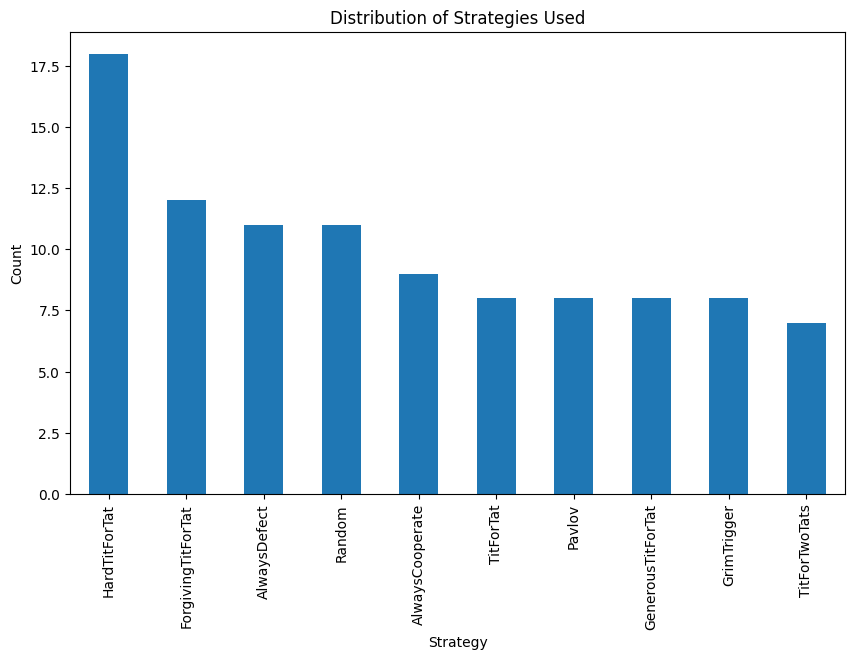

In [9]:
# Plotting the distribution of strategies
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
strategy_distribution.plot(kind='bar')
plt.title('Distribution of Strategies Used')
plt.xlabel('Strategy')
plt.ylabel('Count')
plt.show()



                       Agent Name       Strategy Used  Cooperation Rate
0         Agent 0 (HardTitForTat)       HardTitForTat          0.098179
1       Agent 1 (AlwaysCooperate)     AlwaysCooperate          0.147040
2             Agent 2 (TitForTat)           TitForTat          0.000482
3             Agent 3 (TitForTat)           TitForTat          0.100410
4          Agent 4 (AlwaysDefect)        AlwaysDefect          0.096167
..                            ...                 ...               ...
95       Agent 95 (HardTitForTat)       HardTitForTat          0.132214
96  Agent 96 (ForgivingTitForTat)  ForgivingTitForTat          0.132664
97  Agent 97 (ForgivingTitForTat)  ForgivingTitForTat          0.141786
98              Agent 98 (Pavlov)              Pavlov          0.132594
99  Agent 99 (ForgivingTitForTat)  ForgivingTitForTat          0.000334

[100 rows x 3 columns]


<Figure size 1000x600 with 0 Axes>

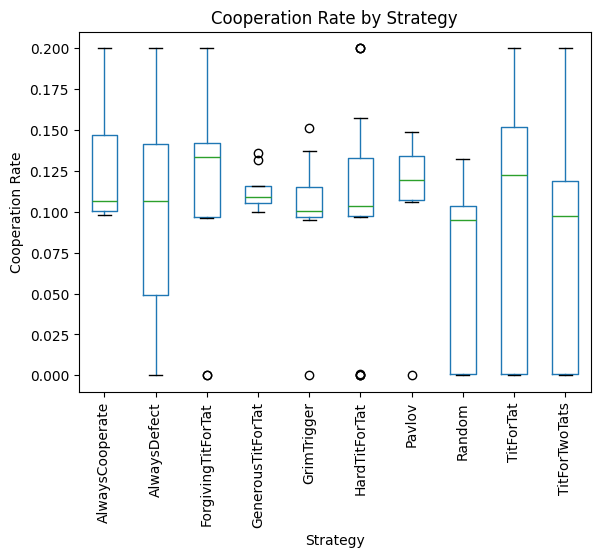

In [10]:
# Analyzing cooperation rates
def cooperation_rate(history):
    return history.count('C') / len(history) if history else 0

df['Cooperation Rate'] = df['History'].apply(cooperation_rate)
print(df[['Agent Name', 'Strategy Used', 'Cooperation Rate']])

# Plotting cooperation rates
plt.figure(figsize=(10, 6))
df.boxplot(column='Cooperation Rate', by='Strategy Used', grid=False, rot=90)
plt.title('Cooperation Rate by Strategy')
plt.suptitle('')
plt.xlabel('Strategy')
plt.ylabel('Cooperation Rate')
plt.show()